## Poisson VCM Results 

This notebook goes over the code needed to reproduce the results from the MSE and time figures for the Poisson base distribution with Log Link and covariance matrix $\Gamma$ structured under variance component model framework as follows:

$$
\Gamma = 0.1 * \mathbf{1_{n} 1_{n}^\top}
$$

In this example simulate three fixed effects under our Quasi-Copula model with $\beta \sim$ rand(Uniform(-2, 2), p) where p = 3 fixed effects.

We run each scenario 100 times and compare the fit of ours with that of GLMM's random intercept model from MixedModels.jl. 

In [1]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


In [2]:
using GLMCopula, DelimitedFiles, LinearAlgebra, Random, GLM
using Random, Roots, SpecialFunctions, DataFrames

In [3]:
p = 3    # number of fixed effects, including intercept
m = 1    # number of variance components
# true parameter values
Random.seed!(12345)
βtrue = rand(Uniform(-2, 2), p)
θtrue = [0.1]

# generate data
intervals = zeros(p + m, 2) #hold intervals
curcoverage = zeros(p + m) #hold current coverage resutls
trueparams = [βtrue; θtrue] #hold true parameters

#simulation parameters
samplesizes = [100; 1000; 10000]
ns = [2; 5; 10; 15; 20; 25]
nsims = 100

100

In [4]:
@info "reading in the files with results"
βMseresult = vec(readdlm("mse_beta_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))
θMseresult = vec(readdlm("mse_Sigma_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))
fittimes_QC = vec(readdlm("fittimes_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))

┌ Info: reading in the files with results
└ @ Main In[4]:1


1800-element Vector{Float64}:
 0.864121122
 0.057107615
 0.062309788
 0.06956311
 0.044633026
 0.03469383
 0.049491863
 0.041078065
 0.044318075
 0.04616432
 0.038448788
 0.035997663
 0.036990709
 ⋮
 1.921069717
 2.087289949
 2.61676599
 2.181480033
 4.822824426
 2.21616618
 1.940637799
 2.382636802
 1.873678063
 2.080615657
 2.240571633
 1.875556744

In [5]:
fittimes_GLMM = vec(readdlm("fittimes_GLMM_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))

1800-element Vector{Float64}:
   1.077584956
   0.03816703
   0.033106057
   0.021729892
 NaN
   0.031593918
   0.023610822
   0.022257294
   0.030345314
   0.024333742
   0.02608666
   0.024643879
 NaN
   ⋮
  24.029364079
  22.307790228
 NaN
 NaN
  22.21904137
  20.447853419
 NaN
  21.893377976
  24.598027201
  24.243559151
  23.601355736
  21.345563398

In [6]:
#simulation parameters
@info "making results table Quasi-Copula"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_QC)
timedf1 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf1, Dict(:fittimes_function => "se"))
timedf1[!, :nobs] = Meta.parse.(timedf1[!, :samplesize]) .* Meta.parse.(timedf1[!, :obssize])
timedf1[!, :fitmin] = timedf1[!, :fittime] - timedf1[!, :se]
timedf1[!, :fitmax] = timedf1[!, :fittime] + 2 * timedf1[!, :se]
timedf1[!, :perobsratio] = timedf1[!, :fittime] ./ timedf1[!, :nobs]
timedf1

┌ Info: making results table Quasi-Copula
└ @ Main In[6]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,100,2,0.0548024,0.00857997,200,0.0462225,0.0719624,0.000274012
2,100,5,0.0366933,0.000571305,500,0.036122,0.037836,7.33867e-5
3,100,10,0.0425077,0.00242242,1000,0.0400852,0.0473525,4.25077e-5
4,100,15,0.0412817,0.000630847,1500,0.0406509,0.0425434,2.75212e-5
5,100,20,0.0449739,0.000651784,2000,0.0443221,0.0462775,2.2487e-5
6,100,25,0.0500377,0.000842988,2500,0.0491947,0.0517237,2.00151e-5
7,1000,2,0.0516913,0.00054738,2000,0.0511439,0.052786,2.58456e-5
8,1000,5,0.0686829,0.000523903,5000,0.068159,0.0697307,1.37366e-5
9,1000,10,0.0910022,0.000625179,10000,0.090377,0.0922525,9.10022e-6


In [7]:
#simulation parameters
@info "making results table GLMM"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_GLMM)
timedf2 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf2, Dict(:fittimes_function => "se"))
timedf2[!, :nobs] = Meta.parse.(timedf2[!, :samplesize]) .* Meta.parse.(timedf2[!, :obssize])
timedf2[!, :fitmin] = timedf2[!, :fittime] - timedf2[!, :se]
timedf2[!, :fitmax] = timedf2[!, :fittime] + timedf2[!, :se]
timedf2[!, :perobsratio] = timedf2[!, :fittime] ./ timedf2[!, :nobs]
timedf2

┌ Info: making results table GLMM
└ @ Main In[7]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,100,2,NaN,NaN,200,NaN,NaN,NaN
2,100,5,NaN,NaN,500,NaN,NaN,NaN
3,100,10,NaN,NaN,1000,NaN,NaN,NaN
4,100,15,0.145015,0.00264579,1500,0.142369,0.14766,9.66764e-5
5,100,20,NaN,NaN,2000,NaN,NaN,NaN
6,100,25,0.237606,0.0033739,2500,0.234232,0.24098,9.50424e-5
7,1000,2,NaN,NaN,2000,NaN,NaN,NaN
8,1000,5,NaN,NaN,5000,NaN,NaN,NaN
9,1000,10,NaN,NaN,10000,NaN,NaN,NaN


┌ Warning: RCall.jl: Warning: package ‘ggplot2’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172
┌ Warning: RCall.jl: Warning: package ‘cowplot’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172
┌ Warning: RCall.jl: Warning: Removed 16 row(s) containing missing values (geom_path).
│ geom_path: Each group consists of only one observation. Do you need to adjust
│ the group aesthetic?
│ Warning: Removed 16 rows containing missing values (geom_point).
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172


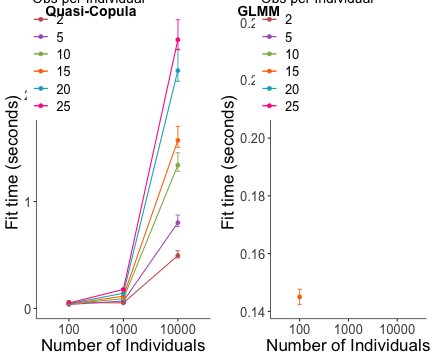

RObject{VecSxp}


In [8]:
########### plot the runtimes
using RCall
@rput timedf1
@rput timedf2
R"""
library(ggplot2)
library(cowplot)
timedf1$obssize = factor(timedf1$obssize, levels = c('2', '5', '10', '15', '20', '25'))
timedf1$samplesize = factor(timedf1$samplesize, levels = c('100', '1000', '10000'))

fittime_1 = ggplot(timedf1, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.3,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")

timedf2$obssize = factor(timedf2$obssize, levels = c('2', '5', '10', '15', '20', '25'))
timedf2$samplesize = factor(timedf2$samplesize, levels = c('100', '1000', '10000'))

fittime_2 = ggplot(timedf2, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.3,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")

fittime_nsamples = plot_grid(fittime_1, fittime_2, labels = c("Quasi-Copula", "GLMM"))
"""

In [9]:
R"""
    ggsave('fittime_nsamples_poisson_vs_glmm_beta_unif2_Sigma_0.1.png', fittime_nsamples, width = 15, height = 17, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "fittime_nsamples_poisson_vs_glmm_beta_unif2_Sigma_0.1.png"


In [10]:
######  supplementary table s1
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem

βθcoverage = readdlm("beta_sigma_coverage_multivariate_poisson_vcm$(nsims)reps_sim.csv", ',')

m  = 1

covdf = DataFrame(Matrix(transpose(βθcoverage)), :auto)
rename!(covdf, Symbol.([["β$i" for i in 1:p]; ["θ$i" for i in 1:m]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats, :auto)
ss_obs = unique("N: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p]; ["θ$i" for i in 1:m]])])
# deletecols!(covdfdisplay, p + 2)
covdfdisplay


,people_obs,β1,β2,β3,θ1
,String,Tuple…,Tuple…,Tuple…,Tuple…
1,N: 100 ni: 2,"(0.64, 0.0482418)","(0.75, 0.0435194)","(0.84, 0.0368453)","(0.94, 0.0238683)"
2,N: 100 ni: 5,"(0.59, 0.0494311)","(0.88, 0.0326599)","(0.8, 0.0402015)","(0.85, 0.035887)"
3,N: 100 ni: 10,"(0.57, 0.049757)","(0.85, 0.035887)","(0.78, 0.0416333)","(0.95, 0.0219043)"
4,N: 100 ni: 15,"(0.62, 0.0487832)","(0.87, 0.0337998)","(0.79, 0.040936)","(0.98, 0.0140705)"
5,N: 100 ni: 20,"(0.44, 0.0498888)","(0.78, 0.0416333)","(0.7, 0.0460566)","(0.94, 0.0238683)"
6,N: 100 ni: 25,"(0.53, 0.0501614)","(0.85, 0.035887)","(0.7, 0.0460566)","(0.93, 0.0256432)"
7,N: 1000 ni: 2,"(0.52, 0.0502117)","(0.84, 0.0368453)","(0.81, 0.0394277)","(0.94, 0.0238683)"
8,N: 1000 ni: 5,"(0.48, 0.0502117)","(0.89, 0.0314466)","(0.84, 0.0368453)","(0.93, 0.0256432)"
9,N: 1000 ni: 10,"(0.43, 0.049757)","(0.93, 0.0256432)","(0.81, 0.0394277)","(0.96, 0.0196946)"


In [11]:
#### 
#import data and reorganize to create figure
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem

βMseresult = vec(readdlm("mse_beta_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))
θMseresult = vec(readdlm("mse_Sigma_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))

βMseresult_GLMM = vec(readdlm("mse_beta_GLMM_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))
θMseresult_GLMM = vec(readdlm("mse_Sigma_GLMM_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))


p = 3; m = 1
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))
msedf1 = DataFrame(βmse = βMseresult, thetamse = θMseresult, 
    samplesize = sample_sizes, obssize = obs_sizes)

msedf2 = DataFrame(βmse = βMseresult_GLMM, thetamse = θMseresult_GLMM, 
    samplesize = sample_sizes, obssize = obs_sizes)

#rename to make parsing easier for R.

msedf1 = deepcopy(msedf1)
rename!(msedf1, ["betamse"
    "thetamse"
    "samplesize"
 "obssize"]);

msedf2 = deepcopy(msedf2)
rename!(msedf2, ["betamse"
    "thetamse"
    "samplesize"
 "obssize"]);

mses = [msedf1[!, :betamse]; msedf1[!, :thetamse]; msedf2[!, :betamse]; msedf2[!, :thetamse]]
    # msedfnormR[!, :betamse]; msedfnormR[!, :taumse]; msedfnormR[!, :Sigmamse]]
obssize = [collect([repeat(msedf1[!, :obssize], 2)]...) ; collect([repeat(msedf2[!, :obssize], 2)]...)]
#40
samplesize = [collect([repeat(msedf1[!, :samplesize], 2)]...) ; collect([repeat(msedf2[!, :samplesize], 2)]...)]

parameters = [collect([repeat(string.([:beta, :theta]), inner = nsims * length(ns) * length(samplesizes))]...) ; collect([repeat(string.([:beta, :theta]), inner = nsims * length(ns) * length(samplesizes))]...)]
robust = [collect([repeat(["Poisson QC"], 2 * nsims * length(ns) * length(samplesizes))]...); collect([repeat(["Poisson GLMM"],  2 * nsims * length(ns) * length(samplesizes))]...)]

msedfR = DataFrame(mse = mses, obssize = obssize, samplesize = samplesize,
    parameters = parameters, robust = robust)

#5 of the 30,000 simulations did not converge, filter out
msedfR = filter(x -> !isnan(x.mse), msedfR)
# additionally, there are 5 where an error was not caught so it did not try a differnt solver
msedfR = filter(x -> x.mse < 40000, msedfR)

,mse,obssize,samplesize,parameters,robust
,Float64,String,String,String,String
1,0.00281954,2,100,beta,Poisson QC
2,0.00197789,2,100,beta,Poisson QC
3,0.00069935,2,100,beta,Poisson QC
4,0.00145787,2,100,beta,Poisson QC
5,0.00257383,2,100,beta,Poisson QC
6,0.00272419,2,100,beta,Poisson QC
7,0.00137838,2,100,beta,Poisson QC
8,0.00119739,2,100,beta,Poisson QC
9,0.00148302,2,100,beta,Poisson QC


┌ Warning: RCall.jl: Warning: package ‘scales’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172
┌ Warning: RCall.jl: Warning: package ‘data.table’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172


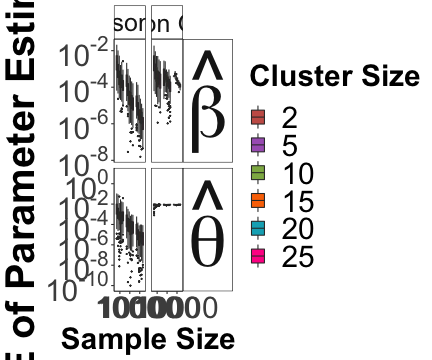

RObject{VecSxp}


In [12]:
### working on figure next
@rput msedfR

R"""
library(scales)
library(ggplot2)
library(data.table)

msedfR = data.table(msedfR)

msedfR[parameters == "beta",y_min := 10^-4]
msedfR[parameters == "beta",y_max := 10^-2]
msedfR[parameters == "theta",y_min := 10^-5]
msedfR[parameters == "theta",y_max := 10^1]

#msedfR[parameters == "beta",y_min := 10^-8]
#msedfR[parameters == "beta",y_max := 10^-2]
#msedfR[parameters == "tau",y_min := 10^-8]
#msedfR[parameters == "tau",y_max := 10^-2]
#msedfR[parameters == "Sigma",y_min := 10^-5]
#msedfR[parameters == "Sigma",y_max := 10^-2]


msedfR$obssize = factor(msedfR$obssize, levels = c('2', '5', '10', '15', '20', '25'))
msedfR$samplesize = factor(msedfR$samplesize, levels = c('100', '1000', '10000'))
msedfR$parameters = factor(msedfR$parameters, levels = c('beta', 'theta'), labels = c(beta = expression(hat(bold(beta))), thetaa = expression(hat(bold(theta))[])))
msedfR$robust <- factor(msedfR$robust, levels = c('Poisson QC', 'Poisson GLMM'),
    labels = c(expression(paste("Poisson QC")), expression(paste("Poisson GLMM"))))


#mseplot <- ggplot(msedfR[msedfR$mse < 10^0, ], aes(x=samplesize, y=mse, fill=obssize)) + 
mseplot = ggplot(msedfR[msedfR$mse < 10^3, ], aes(x=samplesize, y=mse, fill=obssize)) + 
  #geom_boxplot(outlier.size = 0.0, outlier.alpha = 0) +
  geom_boxplot(outlier.size = 0.25) +
#    geom_violin() +
    facet_grid(parameters ~ robust, labeller = label_parsed, scales = "free_y") +
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=30),
        axis.text.y = element_text(angle=0, size=30), axis.title.x = element_text(size = 30, face="bold"), 
        axis.title.y = element_text(size = 40, face="bold"), legend.title = element_text(size = 30, face="bold"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.text=element_text(size=30), panel.background = element_rect(fill = NA, color = "black"),
        #panel.background = element_blank(), #panel.border = element_blank(),
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5),
        strip.background = element_rect(colour="black", fill="white"), strip.text.y = element_text(angle = 0, size=75, face="bold"),
        strip.text.x = element_text(size=25)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
#scale_y_log10(breaks = 10^(-8:8), limit=c(10^-8, 10^2)) + 
scale_y_log10(breaks = 10^seq(-10, 10, 2), labels=trans_format("log10", math_format(10^.x))) + #, limit=c(10^-8, 10^2)) +
  labs(x = "Sample Size", y = "MSE of Parameter Estimates", fill = "Cluster Size") +
geom_blank(aes(y = y_max)) + 
geom_blank(aes(y = y_min)) 

"""

In [13]:
R"""
ggsave('updated_msefacetplot_poisson_beta_unif_2_sigma_0.1.png', mseplot, width = 20, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "updated_msefacetplot_poisson_beta_unif_2_sigma_0.1.png"
